# 1. Import modules and load data

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from scipy.stats import chi2_contingency, fisher_exact
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv('roblox_games.csv')
df.head()

,UniverseId,Name,Genre,Created Date,Updated Date,Max Players,Playability Status,Is Experimental,Price,Visits,Developer,Thumbnail URL,PlayerCount,Upvotes,Downvotes
0,5750914919,[UPD] ❄️ Fisch,Adventure,2024-03-13T15:03:39.63Z,2024-12-14T22:26:01.4086765Z,23,NaN,False,NaN,810023893,Fisching,NaN,459379,705911,111565
1,383310974,[WINTER❄️] Adopt Me!,RPG,2017-07-14T19:26:21.347Z,2024-12-13T19:50:10.8662986Z,48,NaN,False,NaN,38085420844,Uplift Games,NaN,137677,7388805,1450790
2,6325068386,[UPD] Blue Lock: Rivals,All,2024-07-26T19:16:18.383Z,2024-12-14T17:48:06.2152726Z,10,NaN,False,NaN,55789963,Blue Lock Rivals Official,NaN,111074,621367,13257
3,3317771874,Pet Simulator 99! 🎁,All,2022-02-05T13:30:02.357Z,2024-12-14T18:26:52.8889068Z,10,NaN,False,NaN,1661741872,BIG Games Pets,NaN,173229,2675392,116036
4,6491900489,Carry an Egg [2 Player Obby],All,2024-08-31T04:42:03.827Z,2024-12-14T16:36:00.5951575Z,12,NaN,False,NaN,43287993,Skeptic Softworks,NaN,27485,9588,3281


# 2. EDA

A brief look into the dataframe:

In [3]:
df['Created Date'] = pd.to_datetime(df['Created Date'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
df['Updated Date'] = pd.to_datetime(df['Updated Date'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
now = datetime.utcnow()
df['Days Since Created'] = (now - df['Created Date']).dt.days
df['Days Since Updated'] = (now - df['Updated Date']).dt.days
df.head()

,UniverseId,Name,Genre,Created Date,Updated Date,Max Players,Playability Status,Is Experimental,Price,Visits,Developer,Thumbnail URL,PlayerCount,Upvotes,Downvotes,Days Since Created,Days Since Updated
0,5750914919,[UPD] ❄️ Fisch,Adventure,2024-03-13 15:03:39.630,2024-12-14 22:26:01.408676500,23,NaN,False,NaN,810023893,Fisching,NaN,459379,705911,111565,277.0,0.0
1,383310974,[WINTER❄️] Adopt Me!,RPG,2017-07-14 19:26:21.347,2024-12-13 19:50:10.866298600,48,NaN,False,NaN,38085420844,Uplift Games,NaN,137677,7388805,1450790,2711.0,2.0
2,6325068386,[UPD] Blue Lock: Rivals,All,2024-07-26 19:16:18.383,2024-12-14 17:48:06.215272600,10,NaN,False,NaN,55789963,Blue Lock Rivals Official,NaN,111074,621367,13257,142.0,1.0
3,3317771874,Pet Simulator 99! 🎁,All,2022-02-05 13:30:02.357,2024-12-14 18:26:52.888906800,10,NaN,False,NaN,1661741872,BIG Games Pets,NaN,173229,2675392,116036,1044.0,1.0
4,6491900489,Carry an Egg [2 Player Obby],All,2024-08-31 04:42:03.827,2024-12-14 16:36:00.595157500,12,NaN,False,NaN,43287993,Skeptic Softworks,NaN,27485,9588,3281,106.0,1.0


Find duplicated and missing values.

In [99]:
info = df.count()
print("The situation of existing values is: ")
print(info)
duplicated_rows = df.duplicated().sum()
print(f"There are {duplicated_rows} duplicated rows.")

The situation of existing values is: 
UniverseId            1143
Name                  1143
Genre                 1143
Created Date          1143
Updated Date          1141
Max Players           1143
Playability Status       0
Is Experimental       1143
Price                   42
Visits                1143
Developer             1143
Thumbnail URL            0
PlayerCount           1143
Upvotes               1143
Downvotes             1143
Days Since Created    1143
Days Since Updated    1141
Created_2024          1143
Genre_Missing         1143
Total Votes           1143
Positive Ratio        1143
dtype: int64
There are 0 duplicated rows.


In [5]:
df.drop_duplicates(inplace=True)
print(f"Removed duplicates. Remaining rows: {len(df)}.")
df = df.dropna(subset=["Created Date"])
print(f"Removed rows with missing 'Created Date'. Remaining rows: {len(df)}.")

Removed duplicates. Remaining rows: 1149.
Removed rows with missing 'Created Date'. Remaining rows: 1143.


3 Research Questions:

* RQ1: Is the missing value in the 'Genre' column (defaulting to "All") related to the game's creation time?
* RQ2: Is the number of active players ('PlayerCount') correlated with creation time, positive ratings, and 'Max Players'?
* RQ3: Is the total number of visits ('Visits') correlated with creation time, positive ratings, and 'Max Players'?

## 2.1 RQ1

In [6]:
df['Created_2024'] = df['Created Date'].dt.year == 2024
df['Genre_Missing'] = df['Genre'].apply(lambda x: x.lower() == 'all')

contingency_genre = pd.crosstab(df['Created_2024'], df['Genre_Missing'])

print("Contingency Table for 'Genre':\n", contingency_genre)

if contingency_genre.values.min() >= 5:
  chi2, p_genre, dof, expected = chi2_contingency(contingency_genre)
  print(f"\nChi-Squared Test p-value for 'Genre': {p_genre}")
else:
  if contingency_genre.shape == (2, 2):
      oddsratio, p_genre = fisher_exact(contingency_genre)
      print(f"\nFisher's Exact Test p-value for 'Genre': {p_genre}")
  else:
      print("Fisher's Exact Test is only applicable for 2x2 tables.")

alpha = 0.05

if p_genre < alpha:
  print("\nThere is a significant association between 'Created' in 2024 and missing 'Genre'.")
else:
  print("\nNo significant association between 'Created' in 2024 and missing 'Genre'.")


Contingency Table for 'Genre':
 Genre_Missing  False  True 
Created_2024               
False            391    382
True              80    290

Chi-Squared Test p-value for 'Genre': 2.3943080964084868e-20

There is a significant association between 'Created' in 2024 and missing 'Genre'.


<ipython-input-6-4fa211e2c1b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Created_2024'] = df['Created Date'].dt.year == 2024
<ipython-input-6-4fa211e2c1b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genre_Missing'] = df['Genre'].apply(lambda x: x.lower() == 'all')


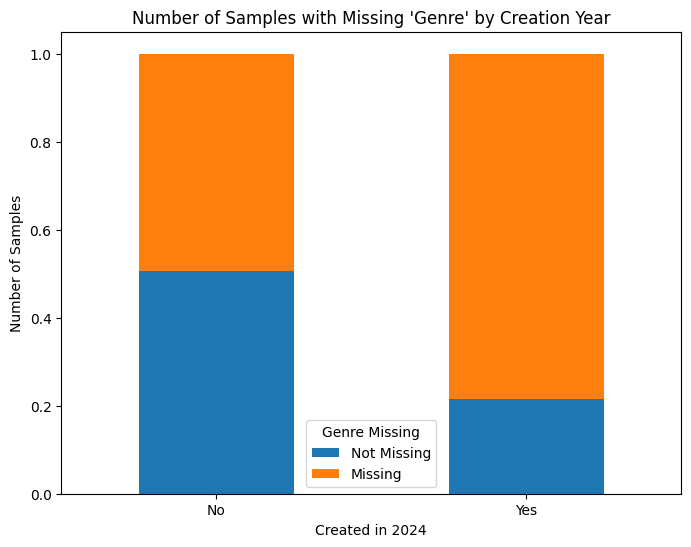

In [7]:
genre_counts = pd.crosstab(df['Created_2024'], df['Genre_Missing'])
genre_percent = genre_counts.div(genre_counts.sum(axis=1), axis=0)

genre_percent.plot(kind='bar', stacked=True, figsize=(8,6))

plt.title("Number of Samples with Missing 'Genre' by Creation Year")
plt.xlabel('Created in 2024')
plt.ylabel('Number of Samples')
plt.xticks([0,1], ['No', 'Yes'], rotation=0)
plt.legend(['Not Missing', 'Missing'], title='Genre Missing')
plt.show()

## 2.2 RQ2

Correlation between Active Players and Days Since Created: 0.0300


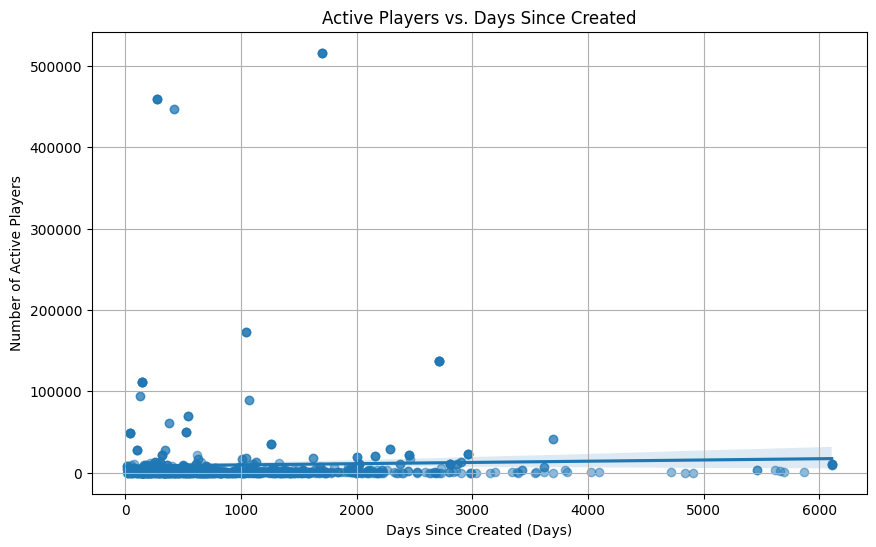

In [8]:
df['Total Votes'] = df['Upvotes'] + df['Downvotes']
df['Positive Ratio'] = df['Upvotes'] / df['Total Votes']
df['Positive Ratio'] = df['Positive Ratio'].replace([float('inf'), -float('inf')], pd.NA)

df_corr = df[['PlayerCount', 'Days Since Created', 'Positive Ratio', 'Max Players', 'Visits']].dropna()

corr_active_age = df_corr['PlayerCount'].corr(df_corr['Days Since Created'])
corr_active_positive_ratio = df_corr['PlayerCount'].corr(df_corr['Positive Ratio'])

print(f"Correlation between Active Players and Days Since Created: {corr_active_age:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(x='Days Since Created', y='PlayerCount', data=df_corr, scatter_kws={'alpha':0.5})
plt.title('Active Players vs. Days Since Created')
plt.xlabel('Days Since Created (Days)')
plt.ylabel('Number of Active Players')
plt.grid(True)
plt.show()

Correlation between Active Players and Positive Ratio: 0.0712


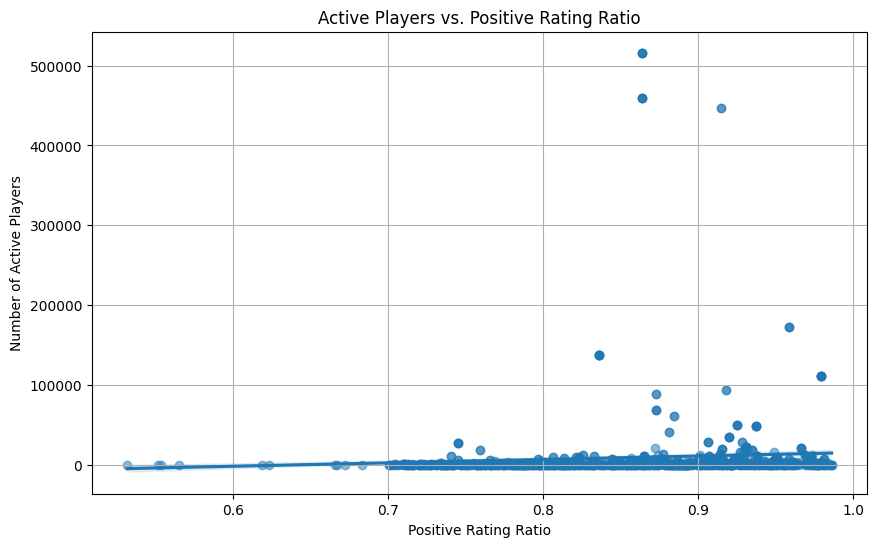

In [9]:
print(f"Correlation between Active Players and Positive Ratio: {corr_active_positive_ratio:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(x='Positive Ratio', y='PlayerCount', data=df_corr, scatter_kws={'alpha':0.5})
plt.title('Active Players vs. Positive Rating Ratio')
plt.xlabel('Positive Rating Ratio')
plt.ylabel('Number of Active Players')
plt.grid(True)
plt.show()

Correlation between Active Players and Max Players: -0.0116


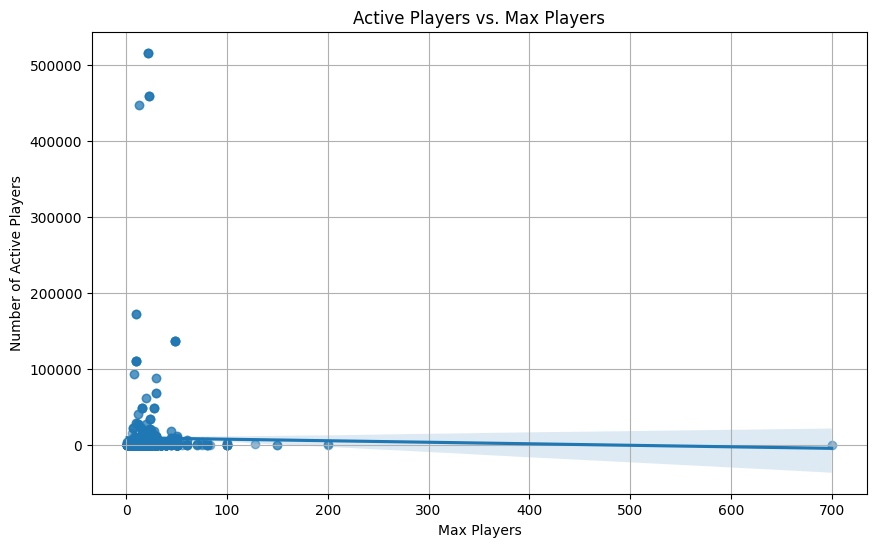

In [10]:
corr_active_max_players = df_corr['PlayerCount'].corr(df_corr['Max Players'])
print(f"Correlation between Active Players and Max Players: {corr_active_max_players:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(x='Max Players', y='PlayerCount', data=df_corr, scatter_kws={'alpha':0.5})
plt.title('Active Players vs. Max Players')
plt.xlabel('Max Players')
plt.ylabel('Number of Active Players')
plt.grid(True)
plt.show()

## 2.3 RQ3

Correlation between Visits and Days Since Created: 0.2267


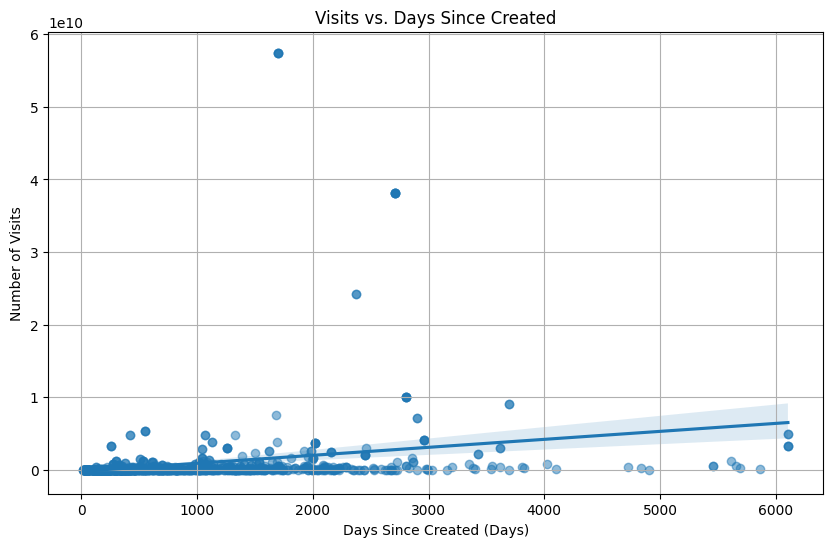

In [11]:
corr_visits_age = df_corr['Visits'].corr(df_corr['Days Since Created'])
print(f"Correlation between Visits and Days Since Created: {corr_visits_age:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(x='Days Since Created', y='Visits', data=df_corr, scatter_kws={'alpha':0.5})
plt.title('Visits vs. Days Since Created')
plt.xlabel('Days Since Created (Days)')
plt.ylabel('Number of Visits')
plt.grid(True)
plt.show()

Correlation between Visits and Positive Rating Ratio: 0.0032


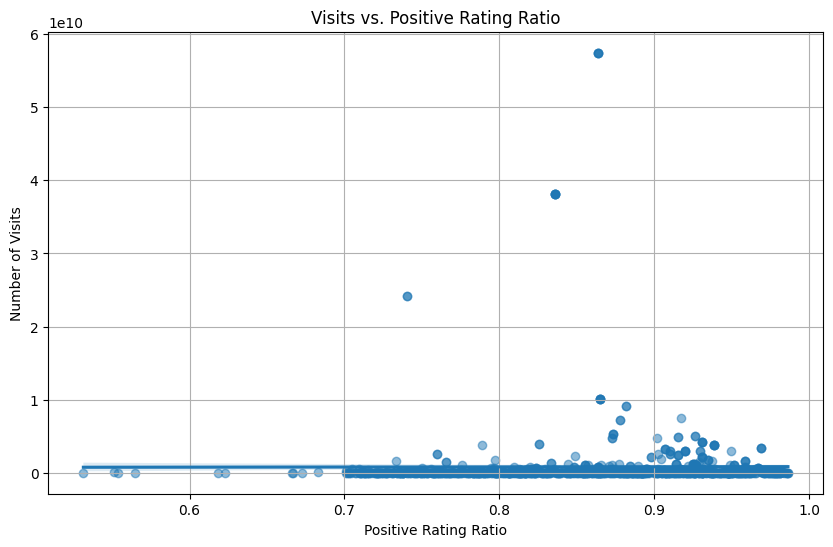

In [12]:
corr_visits_positive_ratio = df_corr['Visits'].corr(df_corr['Positive Ratio'])
print(f"Correlation between Visits and Positive Rating Ratio: {corr_visits_positive_ratio:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(x='Positive Ratio', y='Visits', data=df_corr, scatter_kws={'alpha':0.5})
plt.title('Visits vs. Positive Rating Ratio')
plt.xlabel('Positive Rating Ratio')
plt.ylabel('Number of Visits')
plt.grid(True)
plt.show()

Correlation between Visits and Max Players: 0.0320


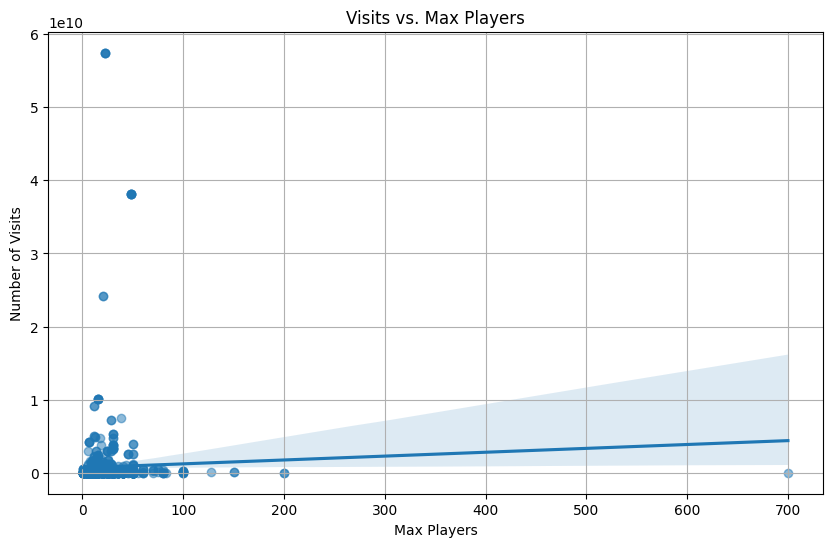

In [13]:
corr_visits_max_players = df_corr['Visits'].corr(df_corr['Max Players'])
print(f"Correlation between Visits and Max Players: {corr_visits_max_players:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(x='Max Players', y='Visits', data=df_corr, scatter_kws={'alpha':0.5})
plt.title('Visits vs. Max Players')
plt.xlabel('Max Players')
plt.ylabel('Number of Visits')
plt.grid(True)
plt.show()

# 3. Machine Learning Analysis

## 3.1 Task 1: Predict Like Rate from Game Features

In [76]:
# Task 1: Predict approval rate based on game attributes
# ===============================================

# Preprocess data for Task 1
# Drop rows where Genre is 'all' or 'Genre_Missing' is True
df_task1 = df[df['Genre_Missing'] == False].copy()

# Compute approval rate
disapproval_rate = df_task1['Downvotes'] / (df_task1['Upvotes'] + df_task1['Downvotes'])
disapproval_rate = disapproval_rate.fillna(0)  # Handle division by zero
df_task1['DisapprovalRate'] = np.sqrt(disapproval_rate)

# Calculate Days Since Created
today = pd.Timestamp.now()
df_task1['DaysSinceCreated'] = (today - pd.to_datetime(df_task1['Created Date'])).dt.days
df_task1['DaysSinceUpdated'] = (today - pd.to_datetime(df_task1['Updated Date'])).dt.days

# Drop rows with missing or invalid data
df_task1 = df_task1.dropna(subset=['Max Players', 'Visits', 'PlayerCount', 'DaysSinceCreated', 'DaysSinceUpdated'])

# One-hot encode Genre
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
genre_encoded = encoder.fit_transform(df_task1[['Genre']])
genre_encoded_df = pd.DataFrame(genre_encoded, columns=encoder.get_feature_names_out(['Genre']))

df_task1

,UniverseId,Name,Genre,Created Date,Updated Date,Max Players,Playability Status,Is Experimental,Price,Visits,...,Downvotes,Days Since Created,Days Since Updated,Created_2024,Genre_Missing,Total Votes,Positive Ratio,DisapprovalRate,DaysSinceCreated,DaysSinceUpdated
0,5750914919,[UPD] ❄️ Fisch,Adventure,2024-03-13 15:03:39.630,2024-12-14 22:26:01.408676500,23,NaN,False,NaN,810023893,...,111565,277.0,0.0,True,False,817476,0.863525,0.369425,277,1.0
1,383310974,[WINTER❄️] Adopt Me!,RPG,2017-07-14 19:26:21.347,2024-12-13 19:50:10.866298600,48,NaN,False,NaN,38085420844,...,1450790,2711.0,2.0,False,False,8839595,0.835876,0.405122,2711,2.0
8,616165168,(NEW) Sunshine Islands Bus Simulator,Town and City,2018-04-04 22:00:05.830,2024-12-09 14:38:10.203000000,17,NaN,False,NaN,14414517,...,3443,2446.0,6.0,False,False,25635,0.865691,0.366481,2447,6.0
9,5956634861,Insomnia,Horror,2024-05-06 10:36:32.427,2024-12-13 17:19:45.307600900,20,NaN,False,NaN,25997460,...,7888,223.0,2.0,True,False,40699,0.806187,0.440242,223,2.0
10,605887098,🎁 XMAS & SHELBY! Car Dealership Tycoon,Adventure,2018-03-27 03:37:58.937,2024-12-14 13:40:37.068008900,15,NaN,False,NaN,2102492656,...,102781,2455.0,1.0,False,False,1482192,0.930656,0.263332,2455,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,5988568657,[XMAS🎄] Care Bears: Caring Quest,Adventure,2024-05-15 00:47:15.587,2024-12-14 06:00:48.652506000,20,NaN,False,NaN,6124008,...,866,214.0,1.0,True,False,11188,0.922596,0.278216,214,1.0
1208,114070244,Roblox Titanic,Adventure,2015-09-06 13:31:56.283,2024-12-13 02:37:59.080000000,30,NaN,False,NaN,307583727,...,53991,3388.0,2.0,False,False,309389,0.825492,0.417742,3388,2.0
1211,112845193,Bird Simulator,Adventure,2015-08-26 17:34:54.980,2023-03-24 08:11:37.810000000,24,NaN,False,NaN,48088941,...,56914,3399.0,632.0,False,False,338504,0.831866,0.410041,3399,632.0
1216,969351457,Math Obby,Adventure,2018-12-28 04:15:41.170,2024-09-20 18:06:56.507000000,10,NaN,False,NaN,31981537,...,16846,2179.0,86.0,False,False,74913,0.775126,0.474209,2179,86.0


In [64]:
# Combine features
X_task1 = pd.concat([
    df_task1[['Max Players', 'Visits', 'PlayerCount', 'DaysSinceCreated', 'DaysSinceUpdated']].reset_index(drop=True),
    genre_encoded_df.reset_index(drop=True)
], axis=1)

X_task1

,Max Players,Visits,PlayerCount,DaysSinceCreated,DaysSinceUpdated,Genre_Adventure,Genre_Building,Genre_Comedy,Genre_FPS,Genre_Fighting,Genre_Horror,Genre_Medieval,Genre_Military,Genre_Naval,Genre_RPG,Genre_Sci-Fi,Genre_Sports,Genre_Town and City,Genre_Western
0,23,810023893,459379,277,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,48,38085420844,137677,2711,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,17,14414517,1970,2447,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,20,25997460,9480,223,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15,2102492656,22232,2455,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,20,6124008,429,214,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466,30,307583727,634,3388,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467,24,48088941,7,3399,632.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
468,10,31981537,11,2179,86.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# Target variable
y_task1 = df_task1['DisapprovalRate']

# Scale features
scaler = StandardScaler()
X_task1_scaled = scaler.fit_transform(X_task1)

# Split dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_task1_scaled, y_task1, test_size=0.2, random_state=42)

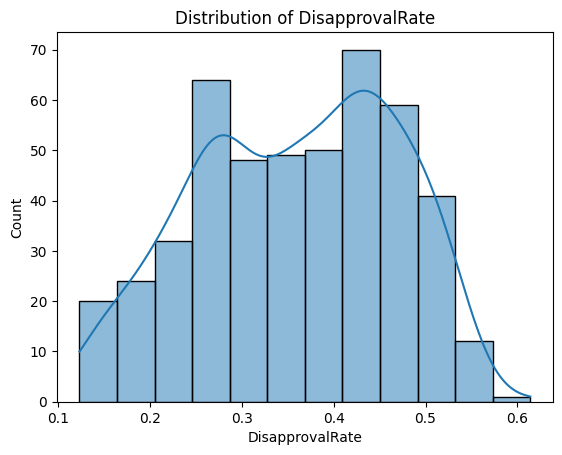

In [78]:
sns.histplot(y_task1, kde=True)
plt.title("Distribution of DisapprovalRate")
plt.show()

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - val_loss: 0.0446 - val_mean_squared_error: 0.0446
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0311 - val_mean

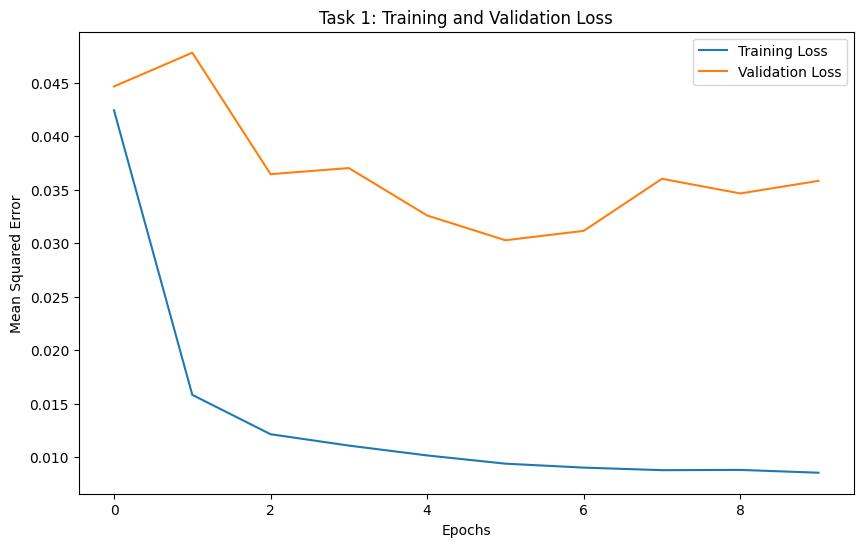

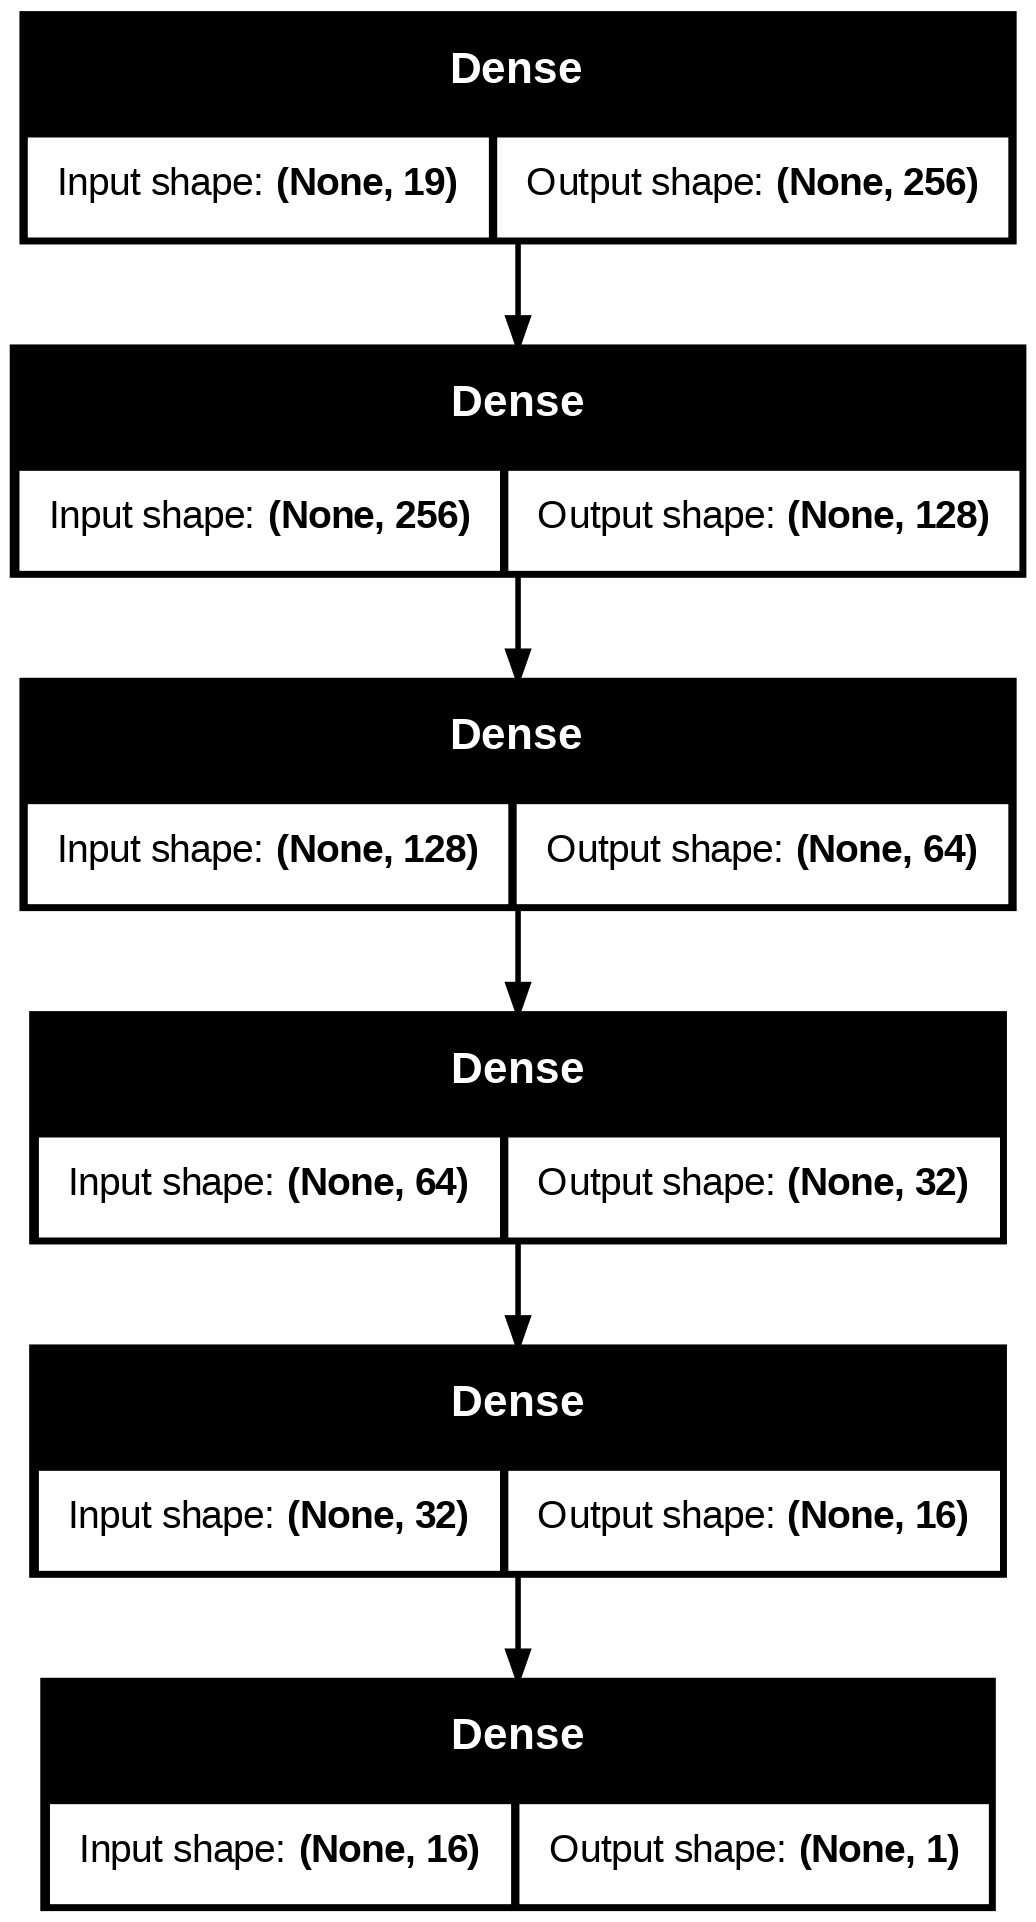

In [94]:
# Build neural network for approval rate prediction (regression)
model1 = Sequential([
    Input(shape=(X_train1.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile with mean squared error loss
model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model for 10 epochs and record history
history = model1.fit(X_train1, y_train1, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
mse, _ = model1.evaluate(X_test1, y_test1)
print(f"Task 1: Neural Network Mean Squared Error: {mse:.4f}")

# Predict on test set
predictions = model1.predict(X_test1).flatten()

r2 = r2_score(y_test1, predictions)
print(f"Task 1: R² Score: {r2:.4f}")

mae = mean_absolute_error(y_test1, predictions)
print(f"Task 1: Mean Absolute Error (MAE): {mae:.4f}")

threshold = 0.1
accuracy = np.mean(np.abs(predictions - y_test1) <= threshold)
print(f"Task 1: Custom Accuracy (±{threshold}): {accuracy:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Task 1: Training and Validation Loss')
plt.legend()
plt.show()

# Plot network structure
plot_model(model1, to_file="task1_model_regression.png", show_shapes=True)


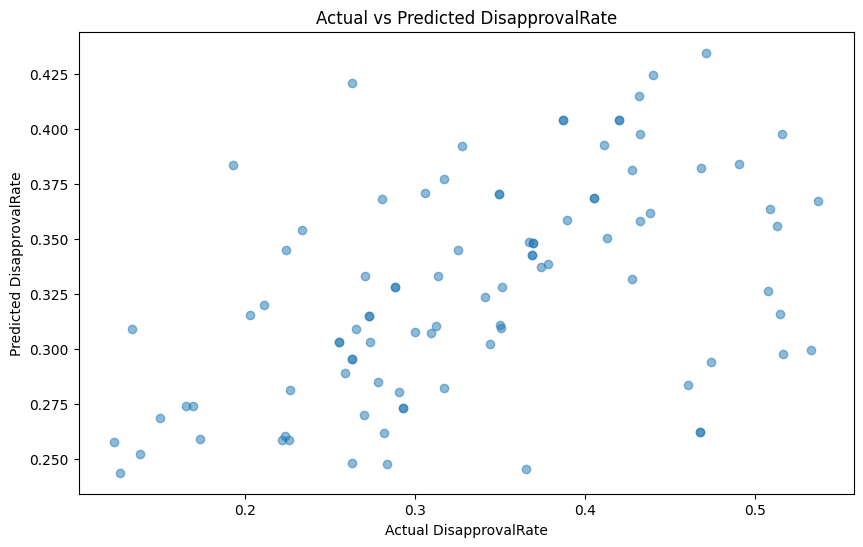

In [95]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test1, predictions, alpha=0.5)
plt.xlabel("Actual DisapprovalRate")
plt.ylabel("Predicted DisapprovalRate")
plt.title("Actual vs Predicted DisapprovalRate")
plt.show()

## 3.2 Task 2: Generate Genre Label from Game Names

In [45]:
# Task 2: Predict Genre based on Name
# Method 1: Naive Bayes
# ===============================================

# Preprocess data for Task 2
# Drop rows where Genre is 'all' or 'GenreIsAll' is True
df_task2 = df[df['Genre_Missing'] == False].copy()

# Target variable
y_task2 = df_task2['Genre']

# Text feature (Name)
X_task2 = df_task2['Name']

# Calculate class weights for imbalanced data
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_task2), y=y_task2)
class_weights_dict = dict(enumerate(class_weights))

# Split dataset
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_task2, y_task2, test_size=0.2, random_state=42)

Task 2: Accuracy: 0.6526
Classification Report:
               precision    recall  f1-score   support

    Adventure       0.61      1.00      0.76        44
     Building       0.00      0.00      0.00         1
       Comedy       0.00      0.00      0.00         5
     Fighting       0.00      0.00      0.00         7
       Horror       0.00      0.00      0.00         4
     Medieval       0.00      0.00      0.00         1
     Military       0.00      0.00      0.00         2
          RPG       1.00      0.22      0.36         9
       Sports       0.78      0.70      0.74        10
Town and City       0.75      0.75      0.75        12

     accuracy                           0.65        95
    macro avg       0.31      0.27      0.26        95
 weighted avg       0.55      0.65      0.56        95



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


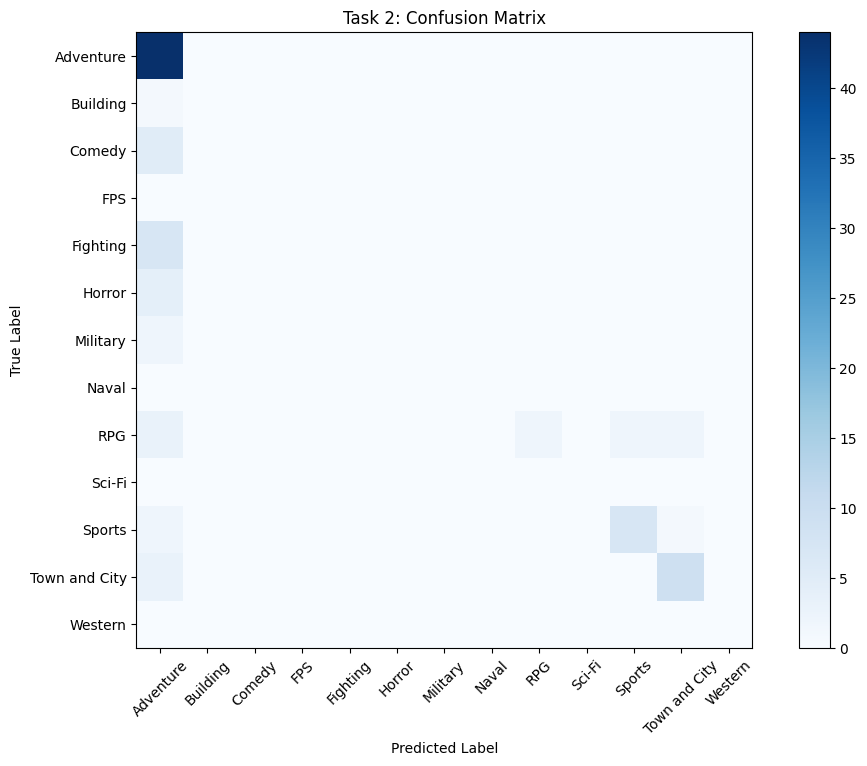

In [46]:
# Create text classification pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

# Train text classification model
text_clf.fit(X_train2, y_train2)

# Predict and evaluate
predictions2 = text_clf.predict(X_test2)
accuracy2 = accuracy_score(y_test2, predictions2)
print(f"Task 2: Accuracy: {accuracy2:.4f}")

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test2, predictions2))

# Plot confusion matrix
cm = confusion_matrix(y_test2, predictions2, labels=text_clf.classes_)
plt.figure(figsize=(12, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Task 2: Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(text_clf.classes_))
plt.xticks(tick_marks, text_clf.classes_, rotation=45)
plt.yticks(tick_marks, text_clf.classes_)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [97]:
# Task 2: Predict Genre based on Name
# Method 2: NN
# ===============================================

# Preprocess data for Task 2
# Drop rows where Genre is 'all' or 'GenreIsAll' is True
df_task2 = df[df['Genre_Missing'] == False].copy()

# Target variable
y_task2 = df_task2['Genre']

# Text feature (Name)
X_task2 = df_task2['Name']

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_task2)
X_task2_seq = pad_sequences(tokenizer.texts_to_sequences(X_task2), maxlen=50)

# Map genres to numerical labels
genre_to_index = {genre: i for i, genre in enumerate(df_task2['Genre'].unique())}
y_task2_numeric = df_task2['Genre'].map(genre_to_index)

# Split dataset
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_task2_seq, y_task2_numeric, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.1809 - loss: 2.6007 - val_accuracy: 0.4211 - val_loss: 2.3755
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.2988 - loss: 2.2675 - val_accuracy: 0.4211 - val_loss: 2.0891
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.3502 - loss: 2.0881 - val_accuracy: 0.4211 - val_loss: 2.0736
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.3683 - loss: 2.1044 - val_accuracy: 0.4211 - val_loss: 2.0601
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3497 - loss: 1.9879 - val_accuracy: 0.4211 - val_loss: 2.0689
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3387 - loss: 2.0020 - val_accuracy: 0.4211 - val_loss: 2.0592
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3482 - loss: 1.9764 - val_accuracy: 0.4211 - val_loss: 2.0587
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3363 - loss: 2.0034 - val_accuracy: 0.4211

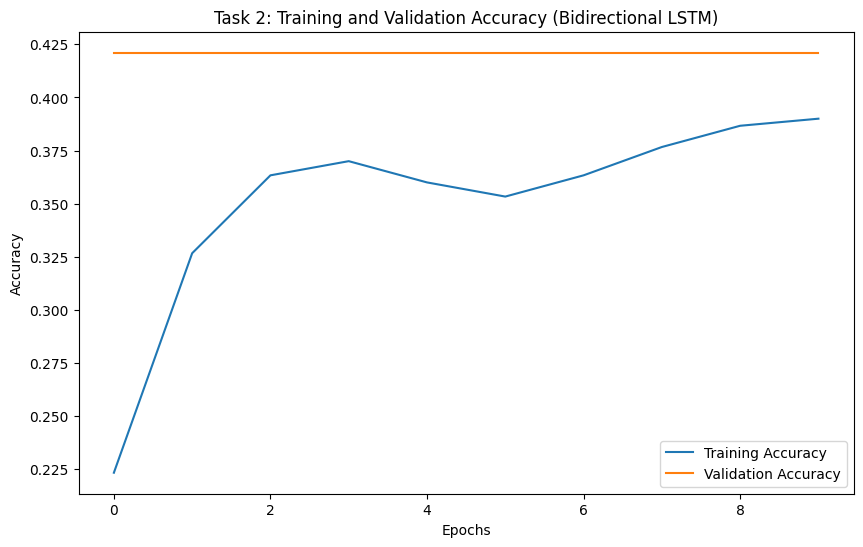

In [98]:
# Build Bidirectional LSTM model
model2 = Sequential([
    Embedding(input_dim=5000, output_dim=100, input_length=50),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(genre_to_index), activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train2, y_train2, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss2, accuracy2 = model2.evaluate(X_test2, y_test2)
print(f"Task 2: Bidirectional LSTM Model Accuracy: {accuracy2:.4f}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Task 2: Training and Validation Accuracy (Bidirectional LSTM)')
plt.legend()
plt.show()
